In [ ]:
import zipfile

zip_path = r'D:\Study Material\Projects\Disease detection\Images.zip'
extract_dir = ''
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [ ]:
import os

PARENT_FOLDER = '/content/PlantVillage/Plant_leave_diseases_dataset_with_augmentation'
classes = sorted([d for d in os.listdir(PARENT_FOLDER) if os.path.isdir(os.path.join(PARENT_FOLDER, d))])
print(f"Found {len(classes)} classes: {classes[:5]} ...")
# Show sample images from one class
first_class = classes[0]
image_count = len(os.listdir(os.path.join(PARENT_FOLDER, first_class)))
print(f"Sample images in {first_class}: {image_count}")


Found 39 classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves'] ...
Sample images in Apple___Apple_scab: 1000


# Phase 1: Classical Computer Vision + Machine Learning – Random Forest


In [ ]:
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from tqdm import tqdm, trange

K_CLUSTERS = 3
MAX_IMAGES_PER_CLASS = 200  # Adjust as needed

def extract_features(image_path, k=K_CLUSTERS):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None
    img = cv2.resize(img, (256, 256))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # HSV color histograms
    h_hist = cv2.calcHist([img_hsv], [0], None, [256], [0,256])
    s_hist = cv2.calcHist([img_hsv], [1], None, [256], [0,256])
    v_hist = cv2.calcHist([img_hsv], [2], None, [256], [0,256])
    h_hist = cv2.normalize(h_hist, h_hist).flatten()
    s_hist = cv2.normalize(s_hist, s_hist).flatten()
    v_hist = cv2.normalize(v_hist, v_hist).flatten()

    # Texture: Laplacian variance
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    texture_feature = np.var(laplacian)

    # K-Means for color clusters
    pixel_values = img_rgb.reshape((-1, 3)).astype(np.float32)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pixel_values)
    cluster_centers = kmeans.cluster_centers_.flatten()
    if len(cluster_centers) < k*3:
        cluster_centers = np.pad(cluster_centers, (0, k*3 - len(cluster_centers)), mode='constant')

    # Final feature vector
    feature_vector = np.hstack([h_hist, s_hist, v_hist, [texture_feature], cluster_centers])
    return feature_vector


In [ ]:
image_label_pairs = []
for class_folder in sorted(os.listdir(PARENT_FOLDER)):
    class_path = os.path.join(PARENT_FOLDER, class_folder)
    if os.path.isdir(class_path):
        image_files = [f for f in sorted(os.listdir(class_path))
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:MAX_IMAGES_PER_CLASS]
        for fname in image_files:
            image_label_pairs.append((os.path.join(class_path, fname), class_folder))

# Extract features, with a single progress bar covering the entire dataset
feature_vector_list, label_list = [], []
for img_path, label in tqdm(image_label_pairs, desc="Extracting features"):
    feat = extract_features(img_path)
    if feat is not None:
        feature_vector_list.append(feat)
        label_list.append(label)

Extracting features: 100%|██████████| 7800/7800 [38:20<00:00,  3.39it/s]


In [ ]:
df_feat = pd.DataFrame({
    'Final_Feature_Vector': feature_vector_list,
    'Label': label_list
})
df_feat.to_pickle('plant_disease_features.pkl')
print("Saved features for future use. Shape:", df_feat.shape)


Saved features for future use. Shape: (7800, 2)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib

X = np.stack(df_feat['Final_Feature_Vector'].values)
y = np.array(df_feat['Label'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

model = RandomForestClassifier(n_estimators=700, random_state=42, n_jobs=-1)
model.fit(X_train, y_train_enc)

joblib.dump(model, "plant_classifier_RF.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']

Accuracy: 0.8917
Classification Report:
                                                precision    recall  f1-score   support

                           Apple___Apple_scab       0.76      0.78      0.77        40
                            Apple___Black_rot       0.84      0.90      0.87        40
                     Apple___Cedar_apple_rust       0.90      0.88      0.89        40
                              Apple___healthy       0.88      0.95      0.92        40
                    Background_without_leaves       1.00      0.97      0.99        40
                          Blueberry___healthy       0.90      0.93      0.91        40
                      Cherry___Powdery_mildew       0.89      0.80      0.84        40
                             Cherry___healthy       0.91      1.00      0.95        40
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.81      0.85      0.83        40
                           Corn___Common_rust       1.00      1.00      1.00        40
 

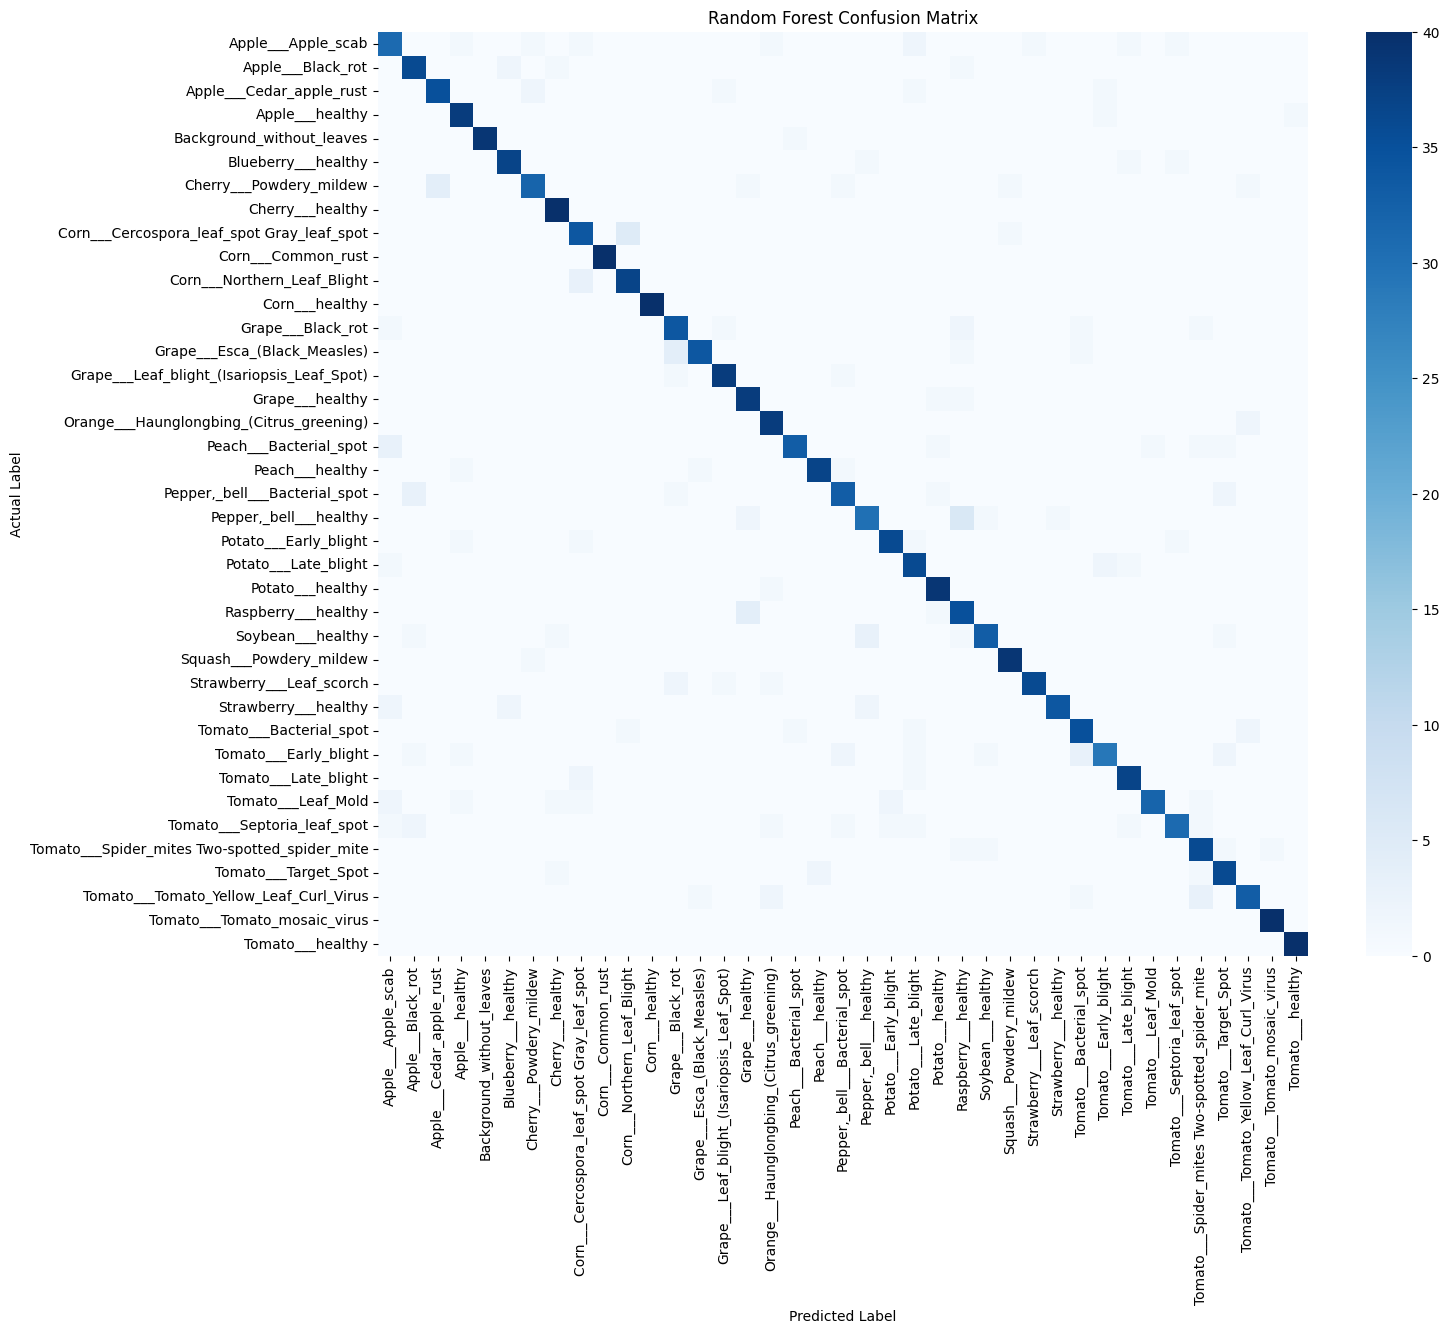

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_enc = model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_enc)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=label_encoder.classes_)
plt.figure(figsize=(15,12))
sns.heatmap(cm, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Random Forest Confusion Matrix')
plt.show()


In [ ]:
def predict_from_image(image_path):
    # Extract features and predict
    feature_vector = extract_features(image_path)
    if feature_vector is None:
        print("Feature extraction failed. Please check the image.")
        return None
    feature_vector = np.array(feature_vector).reshape(1, -1)
    pred_idx = model.predict(feature_vector)[0]
    label = label_encoder.inverse_transform([pred_idx])[0]
    print(f"Predicted class: {label}")
    return label


In [ ]:
 test_image = '/content/PlantVillage/Plant_leave_diseases_dataset_with_augmentation/Grape___healthy/image (3).JPG'
 prediction = predict_from_image(test_image)


Predicted class: Grape___healthy


#  Phase 2: Deep Learning with a Custom CNN

In [3]:
import os

dataset_dir = 'Plant_leave_diseases_dataset_with_augmentation'
classes = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
print(f"Detected {len(classes)} classes.")

Detected 39 classes.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)



Found 49197 images belonging to 39 classes.
Found 12289 images belonging to 39 classes.


In [5]:
from tensorflow.keras import layers, models

n_classes = train_gen.num_classes

def build_cnn(input_shape, n_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

cnn_model = build_cnn(IMG_SIZE + (3,), n_classes)
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
EPOCHS = 15

history = cnn_model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    verbose=1
)

cnn_model.save('cnn_model.h5')
print("Saved trained model as cnn_model.h5")


Epoch 1/15


1538/1538 [==============================] - 1067s 693ms/step - loss: 1.3056 - accuracy: 0.6238 - val_loss: 0.5387 - val_accuracy: 0.8329
Epoch 2/15
1538/1538 [==============================] - 352s 229ms/step - loss: 0.6027 - accuracy: 0.8118 - val_loss: 0.3466 - val_accuracy: 0.8919
Epoch 3/15
1538/1538 [==============================] - 350s 227ms/step - loss: 0.4061 - accuracy: 0.8705 - val_loss: 0.2539 - val_accuracy: 0.9193
Epoch 4/15
1538/1538 [==============================] - 326s 212ms/step - loss: 0.3037 - accuracy: 0.9002 - val_loss: 0.2167 - val_accuracy: 0.9339
Epoch 5/15
1538/1538 [==============================] - 327s 213ms/step - loss: 0.2436 - accuracy: 0.9198 - val_loss: 0.2277 - val_accuracy: 0.9292
Epoch 6/15
1538/1538 [==============================] - 330s 215ms/step - loss: 0.2045 - accuracy: 0.9336 - val_loss: 0.2791 - val_accuracy: 0.9201
Epoch 7/15
1538/1538 [==============================] - 330s 215ms/step - loss: 0.1774 - accuracy: 0.9418 - v

c:\Users\Parth\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


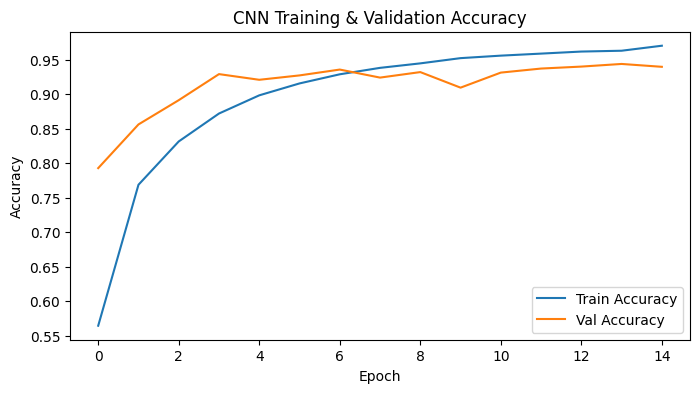

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Phase 3: Transfer Learning with EfficientNetB4

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)  # EfficientNetB4 default
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    '/content/PlantVillage/Plant_leave_diseases_dataset_with_augmentation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle= True
)

val_gen = datagen.flow_from_directory(
    '/content/PlantVillage/Plant_leave_diseases_dataset_with_augmentation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 49197 images belonging to 39 classes.
Found 12289 images belonging to 39 classes.


In [4]:
import os

root_dir =     '/content/PlantVillage/Plant_leave_diseases_dataset_with_augmentation'
  # update as needed
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    print(f"{class_name}: {len(os.listdir(class_path)) if os.path.isdir(class_path) else 'not a folder'}")


Strawberry___Leaf_scorch: 1109
Strawberry___healthy: 1000
Cherry___healthy: 1000
Potato___Late_blight: 1000
Blueberry___healthy: 1502
Corn___Common_rust: 1192
Orange___Haunglongbing_(Citrus_greening): 5507
Raspberry___healthy: 1000
Potato___healthy: 1000
Grape___Black_rot: 1180
Tomato___Early_blight: 1000
Corn___Cercospora_leaf_spot Gray_leaf_spot: 1000
Tomato___Spider_mites Two-spotted_spider_mite: 1676
Peach___healthy: 1000
Tomato___Bacterial_spot: 2127
Apple___Black_rot: 1000
Tomato___healthy: 1591
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076
Tomato___Leaf_Mold: 1000
Grape___Esca_(Black_Measles): 1383
Peach___Bacterial_spot: 2297
Pepper,_bell___healthy: 1478
Apple___healthy: 1645
Corn___healthy: 1162
Apple___Cedar_apple_rust: 1000
Apple___Apple_scab: 1000
Cherry___Powdery_mildew: 1052
Potato___Early_blight: 1000
Squash___Powdery_mildew: 1835
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 5357
Soybean___healthy: 5090
Pepper,_bell___Bacterial_spot: 1000
Tomato___Tomato_mosaic_virus: 1000

In [9]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers, Model

base_model = EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE+(3,),
    pooling='avg'
)
base_model.trainable = False  # Start with frozen weights

inputs = layers.Input(shape=IMG_SIZE+(3,))
x = base_model(inputs, training=False)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(train_gen.num_classes, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [10]:
EPOCHS_INITIAL = 5
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_INITIAL
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1538/1538 ━━━━━━━━━━━━━━━━━━━━ 297s 164ms/step - accuracy: 0.0944 - loss: 3.5205 - val_accuracy: 0.1005 - val_loss: 3.4122
Epoch 2/5
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 178s 116ms/step - accuracy: 0.1166 - loss: 3.4504 - val_accuracy: 0.1265 - val_loss: 3.3595
Epoch 3/5
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 177s 115ms/step - accuracy: 0.1218 - loss: 3.4064 - val_accuracy: 0.1345 - val_loss: 3.3054
Epoch 4/5
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 177s 115ms/step - accuracy: 0.1281 - loss: 3.3874 - val_accuracy: 0.1387 - val_loss: 3.2943
Epoch 5/5
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 177s 115ms/step - accuracy: 0.1328 - loss: 3.3716 - val_accuracy: 0.1461 - val_loss: 3.2614


In [11]:
base_model.trainable = True  # Unfreeze for full fine-tuning
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS_FINE = 2
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FINE
)

Epoch 1/2
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 782s 415ms/step - accuracy: 0.8076 - loss: 0.7192 - val_accuracy: 0.0189 - val_loss: 11.5414
Epoch 2/2
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 563s 366ms/step - accuracy: 0.9617 - loss: 0.1307 - val_accuracy: 0.0186 - val_loss: 12.1685


In [12]:
model.save('efficientnetb4_model.h5')
print("Model saved as efficientnetb4_model.h5")


Model saved as efficientnetb4_model.h5


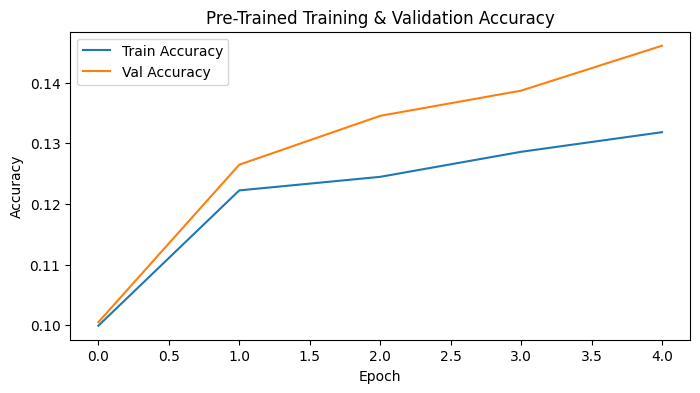

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Pre-Trained Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()